# 04. Developing Probability Functions

Now that we have the dataset more or less ready to work with we can start developing the probability functions that will drive the simulation and the agent behavior.

Sometimes, it makes sense to just sample from previous history when trying to simulate new agent behavior, however in other cases it might makes sense to think of the agent behavior as originating from some stochastic process and then try to use the data to make a model of that process. And when running the simulation you are just sampling from that process.

There are multiple ways of doing this and here we will explore a few possible options

Now we need to two functions

1. A function that says given my previous shopping history what is the probability that I will shop again?
2. what is the probability that a new shopper (i.e. agent is initilized? set this equal to the growth rate so for each the )

In [2]:
# Load and import libraries
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Load data

In [3]:
training_data = pd.read_feather('/home/hcekne/data/online_retail_ii/training_data.feather')

In [4]:
training_data.to_csv('/home/hcekne/data/online_retail_ii/training_data.csv')

## 01. Calculating base growth rates

In [5]:
# Sort the data by 'InvoiceDate'
training_data_sorted = training_data.sort_values('InvoiceDate')

# Drop duplicates to retain only the first appearance (purchase) of each customer
first_purchase_data = training_data_sorted.drop_duplicates(subset='Customer ID', keep='first').reset_index()

first_purchase_data.drop(columns=['Invoice', 'StockCode', 'Description','Quantity', 'Price','index'], inplace=True)

first_purchase_data['InvoiceDate']

# Calculate the number of new customers each month
new_customers_per_month = first_purchase_data.groupby('YearMonth').size()
# Compute the growth rate
growth_rates = new_customers_per_month.pct_change().dropna()

growth_rates.mean()

## Looking at monthly growth rates for customers gives us an average growth rate of -6.5%. This means that on average the number of new customers shopping every month would fall by about 6.5% from the last month.

## For our simulations this can serve as a useful starting point and we can recalculate, on a simulation by simulation basis as we run experiments.

-0.06562496090704593

In [6]:
## Also from the analysis of daily new customers we see that there is a slight difference in when new customers join based on which day of the week so for each day of the week we can sample from a different distribution.

In [7]:
# Calculate daily new customers count
daily_new_customers = first_purchase_data.groupby('InvoiceDate').agg({'Customer ID': 'nunique'})

In [8]:
daily_new_customers['Customer ID'].sum()

5127

In [28]:
daily_new_customers

,InvoiceDate,newCustomerCount
0,2009-12-01,117
1,2009-12-02,95
2,2009-12-03,102
3,2009-12-04,72
4,2009-12-05,25
...,...,...
460,2011-07-04,1
461,2011-07-05,4
462,2011-07-06,1
463,2011-07-07,6


In [12]:
daily_new_customers.reset_index(inplace=True)

In [15]:
daily_new_customers.columns= ['InvoiceDate','newCustomerCount']

In [40]:
daily_new_customers['InvoiceDatetime'] = daily_new_customers['InvoiceDate'].apply(lambda x: pd.Period.to_timestamp(x))

In [16]:
# so most days we don't have any new customers and most of the new customers are at the beginning of the dataset
# we could just sample from this discrete probability distribution to sample how many new customers we could expect to observe 
# however it's more likely a continuous distribution so we could try to fit a distribution and sample from that. For simplicity we just sample from the dataset so

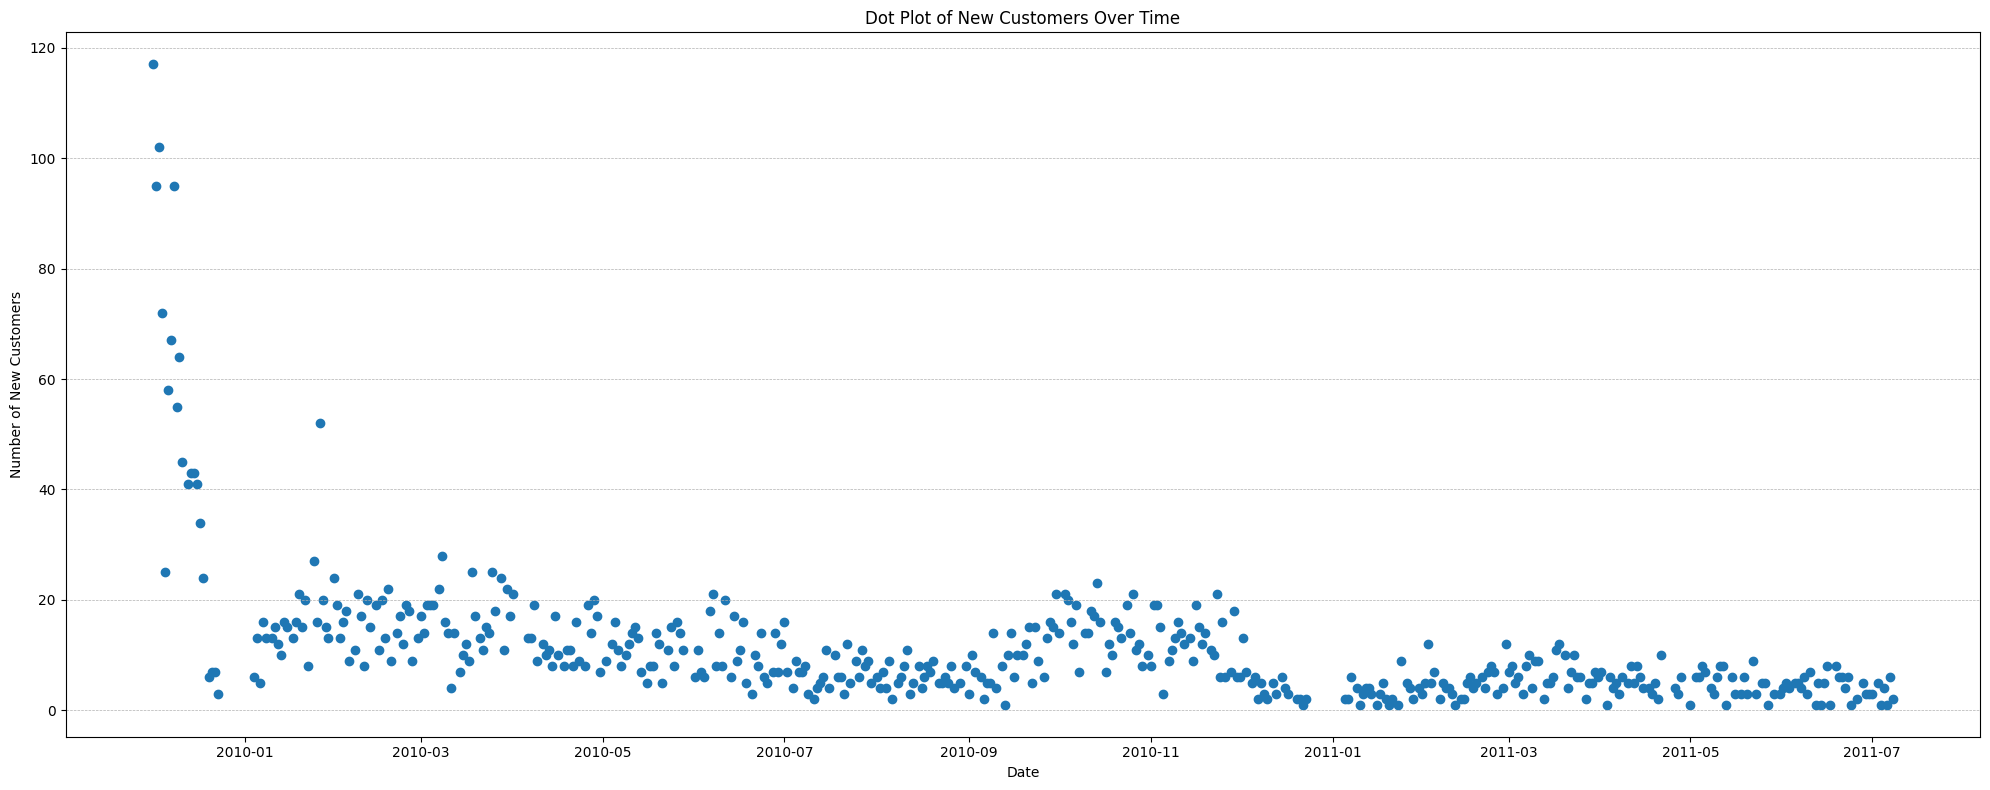

In [43]:
# Dot plot of new customers over time
plt.figure(figsize=(20, 8))
plt.scatter(daily_new_customers['InvoiceDatetime'], daily_new_customers['newCustomerCount'], marker='o')
plt.title('Dot Plot of New Customers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Customers')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

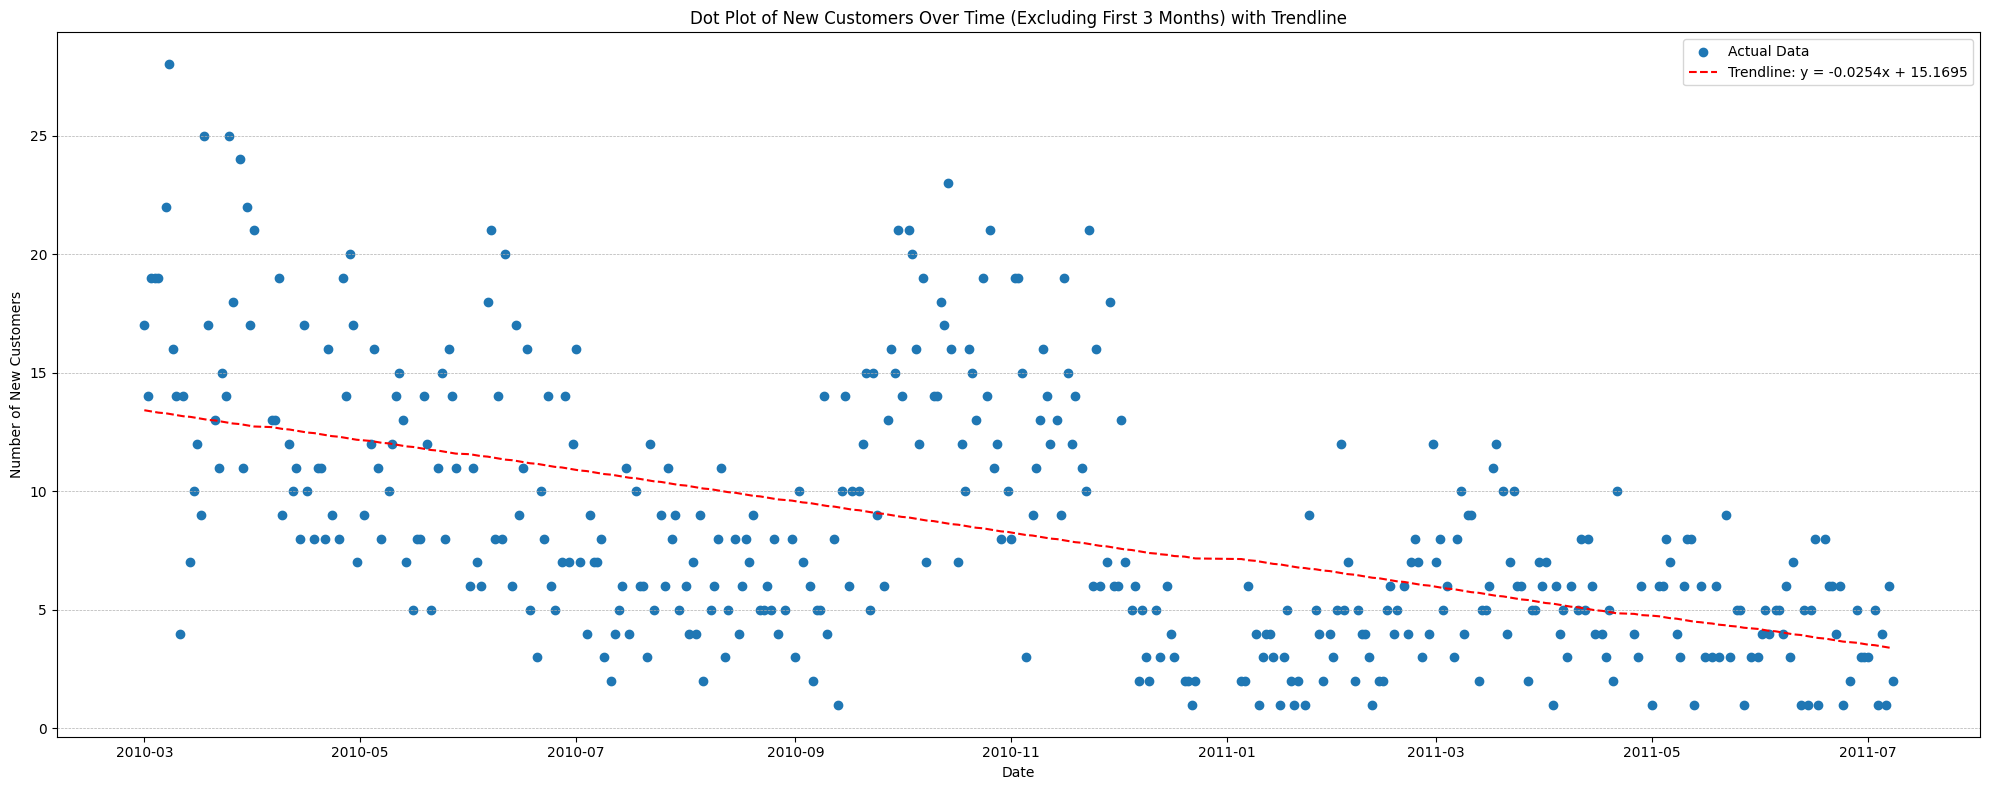

In [44]:

# Exclude the first three months of data
start_date = daily_new_customers['InvoiceDatetime'].min() + pd.DateOffset(months=3)
filtered_data = daily_new_customers[daily_new_customers['InvoiceDatetime'] >= start_date]

# Fit a trendline
z = np.polyfit(filtered_data.index, filtered_data['newCustomerCount'], 1)
p = np.poly1d(z)

# Plot the data and the trendline
plt.figure(figsize=(20, 8))
plt.scatter(filtered_data['InvoiceDatetime'], filtered_data['newCustomerCount'], marker='o', label='Actual Data')
plt.plot(filtered_data['InvoiceDatetime'], p(filtered_data.index), "r--", label=f'Trendline: y = {z[0]:.4f}x + {z[1]:.4f}')
plt.title('Dot Plot of New Customers Over Time (Excluding First 3 Months) with Trendline')
plt.xlabel('Date')
plt.ylabel('Number of New Customers')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# so lets just sample from this distribution with the daily growth factor given by the slope of the trendline.

# Exclude the first 3 months of data
filtered_data = daily_new_customers[90:].copy()

# Represent dates numerically: number of days since the start
filtered_data['DaysSinceStart'] = range(len(filtered_data))

# Set X and Y for regression
X = filtered_data['DaysSinceStart']
y = filtered_data['newCustomerCount']

# Prepare data for scikit-learn linear regression
X = filtered_data['DaysSinceStart'].values.reshape(-1, 1)
y = filtered_data['newCustomerCount'].values

# Initialize linear regression model
lr = LinearRegression()

# Fit the model to the data
lr.fit(X, y)

# Extract the slope (coefficient of DaysSinceStart)
slope_sklearn = lr.coef_[0]
slope_sklearn

-0.023441347138468523

In [46]:
# so we can run the model with the observerd slope coefficient and the recalculate this for every month of the simulation.

In [47]:
# TODO: We need to put this into a functional form that can be used in the simulations

At this point we can now estimate the number of new potential customers coming in so then it remains to estimate which of our current customers repeat shop.

---

## Modelling Probability of Repeat Shopping

In [48]:
### We use the seasonality adjusment factor discovered in the data deep dive to 

## Implementing average duration and duration until censoring  columns for shopping probability

In [49]:
# Dropping the unnecessary 'Unnamed: 0' column
#training_data.drop('Unnamed: 0', axis=1, inplace=True)

# Converting 'InvoiceDatetime' to datetime format
#training_data['InvoiceDatetime'] = pd.to_datetime(training_data['InvoiceDatetime'])

# Sorting the data by 'Customer ID' and 'InvoiceDatetime'
training_data.sort_values(by=['Customer ID', 'InvoiceDatetime'], inplace=True)

# Resetting the index
training_data.reset_index(drop=True, inplace=True)

# Calculate the time difference between consecutive purchases for the same customer
training_data['Duration'] = training_data.groupby('Customer ID')['InvoiceDatetime'].diff().dt.days

# Censoring time
# This would be the difference between the last purchase date of each customer and the last date in the dataset
last_date_in_data = training_data['InvoiceDatetime'].max()
training_data['DurationUntilCensoring'] = last_date_in_data - training_data.groupby('Customer ID')['InvoiceDatetime'].transform('max')
training_data['DurationUntilCensoring'] = training_data['DurationUntilCensoring'].dt.days

# Average duration between shops for each customer
average_duration = training_data.groupby('Customer ID')['Duration'].mean().reset_index()
average_duration.columns = ['Customer ID', 'AvgDuration']

# Number of shops for each customer
num_shops = training_data.groupby('Customer ID')['Invoice'].nunique().reset_index()
num_shops.columns = ['Customer ID', 'NumShops']

# Merge average duration and number of shops into a single DataFrame
customer_info = pd.merge(average_duration, num_shops, on='Customer ID')

# Add DurationUntilCensoring
last_shop_info = training_data.groupby('Customer ID')['DurationUntilCensoring'].first().reset_index()
customer_info = pd.merge(customer_info, last_shop_info, on='Customer ID')

customer_info.head()


,Customer ID,AvgDuration,NumShops,DurationUntilCensoring
0,12347.0,1.273256,5,29
1,12348.0,4.021277,4,94
2,12349.0,3.075472,4,253
3,12350.0,0.000000,1,156
4,12351.0,0.000000,1,221


In [59]:
# order it by customer and duration until cencosring and choose the first value and choose uniques..then find basket size...

training_data

,Invoice,StockCode,Description,Quantity,InvoiceDatetime,Price,Customer ID,Country,TotalSpending,PriceCategory,YearMonth,InvoiceDate,Weekday,Duration,DurationUntilCensoring
0,529924,22698,PINK REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700001,Very Low,2010-10,2010-10-31,Sunday,NaN,29
1,529924,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700001,Very Low,2010-10,2010-10-31,Sunday,0.0,29
2,529924,20985,HEART CALCULATOR,12,2010-10-31 14:20:00,1.25,12347.0,Iceland,15.000000,Very Low,2010-10,2010-10-31,Sunday,0.0,29
3,529924,22418,10 COLOUR SPACEBOY PEN,24,2010-10-31 14:20:00,0.85,12347.0,Iceland,20.400002,Very Low,2010-10,2010-10-31,Sunday,0.0,29
4,529924,22422,TOOTHPASTE TUBE PEN,12,2010-10-31 14:20:00,0.65,12347.0,Iceland,7.800000,Very Low,2010-10,2010-10-31,Sunday,0.0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600984,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,36,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,59.399998,Very Low,2011-05,2011-05-22,Sunday,0.0,47
600985,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,60,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,87.000000,Very Low,2011-05,2011-05-22,Sunday,0.0,47
600986,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,19.799999,Very Low,2011-05,2011-05-22,Sunday,0.0,47
600987,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,19.799999,Very Low,2011-05,2011-05-22,Sunday,0.0,47


In [58]:
customer_info[(customer_info['Customer ID'] == 12347.0)]   #| (customer_info['Customer ID'] ==12348.0)]

,Customer ID,AvgDuration,NumShops,DurationUntilCensoring
0,12347.0,1.273256,5,29


In [50]:
customer_info.sort_values(by=['NumShops', 'AvgDuration'], inplace=True)

In [52]:
customer_info.tail(20)

,Customer ID,AvgDuration,NumShops,DurationUntilCensoring
2298,15039.0,0.224719,91,0
3150,16029.0,1.908451,92,0
874,13408.0,0.877419,93,0
1221,13798.0,0.696615,104,1
106,12471.0,0.531311,108,1
4835,17949.0,3.927536,109,8
4969,18102.0,0.716710,114,4
1949,14646.0,0.187192,120,10
3498,16422.0,0.858065,121,2
2318,15061.0,0.638372,122,2


In [53]:
training_data

,Invoice,StockCode,Description,Quantity,InvoiceDatetime,Price,Customer ID,Country,TotalSpending,PriceCategory,YearMonth,InvoiceDate,Weekday,Duration,DurationUntilCensoring
0,529924,22698,PINK REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700001,Very Low,2010-10,2010-10-31,Sunday,NaN,29
1,529924,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700001,Very Low,2010-10,2010-10-31,Sunday,0.0,29
2,529924,20985,HEART CALCULATOR,12,2010-10-31 14:20:00,1.25,12347.0,Iceland,15.000000,Very Low,2010-10,2010-10-31,Sunday,0.0,29
3,529924,22418,10 COLOUR SPACEBOY PEN,24,2010-10-31 14:20:00,0.85,12347.0,Iceland,20.400002,Very Low,2010-10,2010-10-31,Sunday,0.0,29
4,529924,22422,TOOTHPASTE TUBE PEN,12,2010-10-31 14:20:00,0.65,12347.0,Iceland,7.800000,Very Low,2010-10,2010-10-31,Sunday,0.0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600984,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,36,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,59.399998,Very Low,2011-05,2011-05-22,Sunday,0.0,47
600985,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,60,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,87.000000,Very Low,2011-05,2011-05-22,Sunday,0.0,47
600986,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,19.799999,Very Low,2011-05,2011-05-22,Sunday,0.0,47
600987,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,19.799999,Very Low,2011-05,2011-05-22,Sunday,0.0,47


In [ ]:
# Calculate the churn score for each customer
customer_info['ChurnScore'] = customer_info['AvgDuration'] / (customer_info['AvgDuration'] + customer_info['DurationUntilCensoring'])

# Create a function to plot the number of customers considered 'churned' at various thresholds
def plot_churned_customers_at_thresholds(churn_scores, thresholds):
    import matplotlib.pyplot as plt
    counts = [sum(churn_scores >= thresh) for thresh in thresholds]
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, counts, marker='o')
    plt.title("Number of Customers Considered 'Churned' at Various Thresholds")
    plt.xlabel("Churn Score Threshold")
    plt.ylabel("Number of Customers")
    plt.grid(True)
    plt.show()

# Define a range of thresholds to explore
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Plot the number of customers that would be considered 'churned' at these thresholds
plot_churned_customers_at_thresholds(customer_info['ChurnScore'], thresholds)


Setting the churn threshold at 0.9 sounds like a good starting point for your simulations. You can indeed experiment later to see how sensitive your model outcomes are to changes in this parameter.

With this final piece in place, your agent-based model would now have a number of features to simulate customer behavior:

Basic Shopping Probability: Determined by the average duration between shops for each customer.
Seasonal Modifiers: To account for changes in shopping frequency based on the time of year.
One-Time Shopper Classification: For customers with only one recorded shopping event.
Churn Score: To flag customers who are likely to have 'churned' and therefore should not be considered in future simulations.

## Not used analysis

In [216]:
monthly_average_sales.sum()

NumberOfUniqueSales    22202.0
all_month_average      22202.0
scalingFactor             12.0
dtype: float64

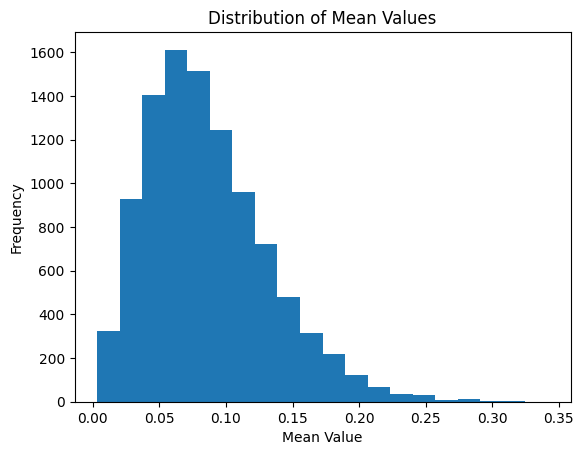

In [165]:
import numpy as np
import random
import matplotlib.pyplot as plt

def run_experiment(shopLength=10000):
    shopHistory = np.zeros(shopLength)
    shopHistory[9] = 1
    shopHistory[19] = 1
    shopHistory[29] = 1
    for i in range(35, shopLength):
        draw = random.random()
        if draw < shopHistory[0:i].mean():
            shopHistory[i] = 1
    return shopHistory[0:shopLength].mean()

num_experiments = 10000
mean_values = []

for _ in range(num_experiments):
    mean_val = run_experiment()
    mean_values.append(mean_val)




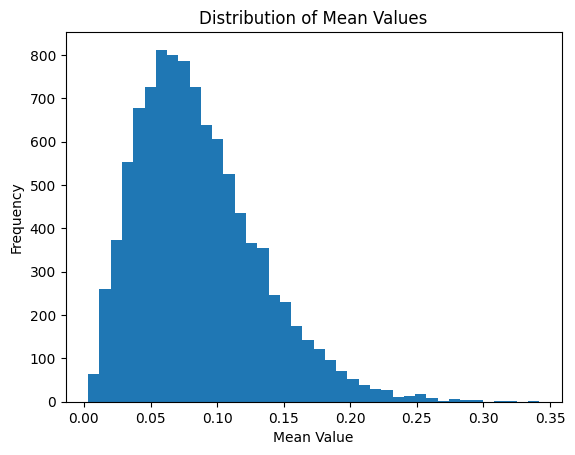

In [166]:
plt.hist(mean_values, bins=40)
plt.xlabel('Mean Value')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Values')
plt.show()

In [168]:
np.array(mean_values).mean()

0.08615236

In [172]:
shopHistory = np.zeros(35)
shopHistory[9] = 1
shopHistory[19] = 1
shopHistory[29] = 1
print(shopHistory.mean())  

0.08571428571428572


Although the average of all the experiments does seem to converge close to our starting average which indicates the simulation approach would have some merit.

Ideas that could have merit would be to for each customer for each timestep either sample and compare against: 

1. Population average - This would eventualy lead to convergence of all agents to the population average, and would over time not result in a realistic simulation.
2. It's own average  - This could work if we had a lot of data on each customer, but some customer have very few observations so the simulation would be sensitive to inital random samples and would quickly establish equilibrium states. However this might even out in the long run when we do many experiments. 
4. A combination of the two
5. The average of similar customers along some  


For our surival analysis we will use the lifelines package, as it is created specifically for this task.

In [178]:
# Group data by Customer ID, InvoiceDate and compute aggregated features 
data_grouped = training_data.groupby(['Customer ID', 'InvoiceDate']).agg({
    'TotalSpending': 'sum',
    'StockCode': 'nunique',
    'Quantity': 'sum'
}).reset_index()


data_grouped['InvoiceDate'] = data_grouped['InvoiceDate'].dt.to_timestamp()

data_grouped.rename(columns={'StockCode': 'NumberOfUniqueProducts'}, inplace=True)

# Sort data by Customer ID and InvoiceDate for proper computation of next purchase date
data_grouped_sorted = data_grouped.sort_values(['Customer ID', 'InvoiceDate'])

# Calculate the difference in days between consecutive purchases for each customer
data_grouped_sorted['NextPurchaseDate'] = data_grouped_sorted.groupby('Customer ID')['InvoiceDate'].shift(-1)

data_grouped_sorted['Duration'] = (data_grouped_sorted['NextPurchaseDate'] - data_grouped_sorted['InvoiceDate']).dt.days

# Define the 'Event' column
data_grouped_sorted['Event'] = data_grouped_sorted['Duration'].notna().astype(int)

# Drop the NextPurchaseDate column for cleanliness
data_grouped_sorted.drop(columns=['NextPurchaseDate'], inplace=True)

data_grouped_sorted.head()

,Customer ID,InvoiceDate,TotalSpending,NumberOfUniqueProducts,Quantity,Duration,Event
0,12347.0,2010-10-31,611.530029,40,509,37.0,1
1,12347.0,2010-12-07,1423.579956,31,638,50.0,1
2,12347.0,2011-01-26,475.390015,29,315,71.0,1
3,12347.0,2011-04-07,636.250000,24,483,63.0,1
4,12347.0,2011-06-09,382.519989,18,196,NaN,0


----

In [181]:
data_customer_grouped = data_grouped_sorted[data_grouped_sorted['Event'] == 1].groupby(['Customer ID']).agg({
    'Duration' : 'mean', 
    'Event': 'sum', 
    'NumberOfUniqueProducts' : 'mean',
    'TotalSpending' : 'mean'
}).reset_index()

In [ ]:
data_customer_grouped = data_grouped_sorted.groupby(['Customer ID']).agg({
    'Duration' : 'mean', 
    'Event': 'sum', 
    'NumberOfUniqueProducts' : 'mean',
    'TotalSpending' : 'mean'
}).reset_index()

data_customer_grouped.rename(columns={'Duration': 'avgDuration', 'Event' : 'countEvents', 'NumberOfUniqueProducts': 'avgUniqueProds', 'TotalSpending': 'avgSpending'}, inplace=True)

In [186]:
data_customer_grouped.to_csv('/home/hcekne/data/online_retail_ii/data_customer_grouped.csv')

In [ ]:
# Plot 1: Histogram of Average Duration between Shops
plt.figure(figsize=(10, 6))
sns.histplot(data_customer_grouped['avgDuration'].dropna(), bins=50, kde=True, color='blue')
plt.title('Histogram of Average Duration Between Shops')
plt.xlabel('Average Duration (Days)')
plt.ylabel('Frequency')
plt.show()

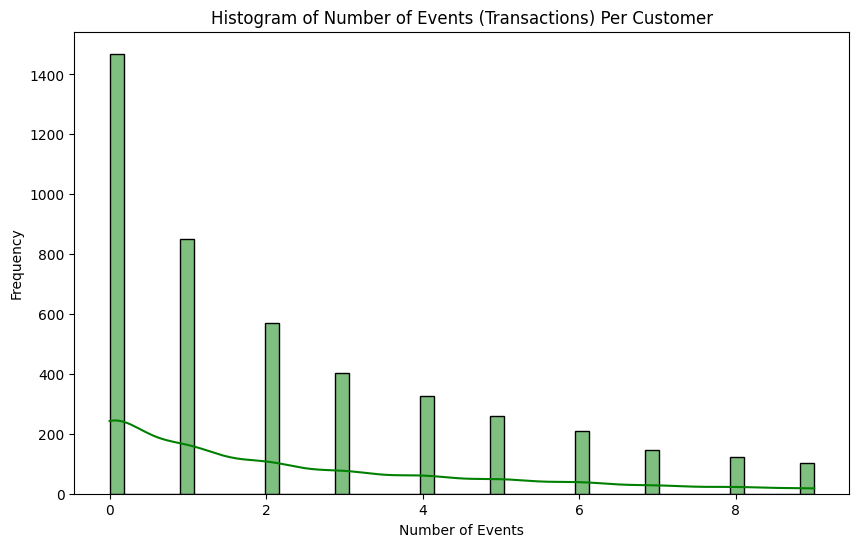

In [189]:
# Plot 2: Histogram of Number of Events (Transactions) Per Customer
plt.figure(figsize=(10, 6))
sns.histplot(data_customer_grouped[data_customer_grouped['countEvents']<10]['countEvents'], bins=50, kde=True, color='green')
plt.title('Histogram of Number of Events (Transactions) Per Customer')
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Plot 3: Histogram of Average Number of Unique Products
plt.figure(figsize=(10, 6))
sns.histplot(data_customer_grouped['avgUniqueProds'].dropna(), bins=50, kde=True, color='orange')
plt.title('Histogram of Average Number of Unique Products')
plt.xlabel('Average Number of Unique Products')
plt.ylabel('Frequency')
plt.show()

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23082 entries, 20160 to 23654
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Customer ID             23082 non-null  float32       
 1   InvoiceDate             23082 non-null  datetime64[ns]
 2   TotalSpending           23082 non-null  float32       
 3   NumberOfUniqueProducts  23082 non-null  int64         
 4   Quantity                23082 non-null  int64         
 5   Duration                18971 non-null  float64       
 6   Event                   23082 non-null  int64         
dtypes: datetime64[ns](1), float32(2), float64(1), int64(3)
memory usage: 1.2 MB


At this point we would run into an issue when fitting the model because the Cox Proportional Hazards model (or most regression models for that matter) can't directly handle datetime values. To capture seasonality, we typically extract features from the datetime that can represent cyclical patterns, such as month, day of week, etc. So let's do that here as well.

In [56]:
# Extract month and day of week
data_grouped_sorted['Month'] = data_grouped_sorted['InvoiceDate'].dt.month
data_grouped_sorted['DayOfWeek'] = data_grouped_sorted['InvoiceDate'].dt.dayofweek

# Convert month and day of week to cyclic features
data_grouped_sorted['Month_sin'] = np.sin(2 * np.pi * data_grouped_sorted['Month'] / 12)
data_grouped_sorted['Month_cos'] = np.cos(2 * np.pi * data_grouped_sorted['Month'] / 12)
data_grouped_sorted['DayOfWeek_sin'] = np.sin(2 * np.pi * data_grouped_sorted['DayOfWeek'] / 7)
data_grouped_sorted['DayOfWeek_cos'] = np.cos(2 * np.pi * data_grouped_sorted['DayOfWeek'] / 7)

# Drop the original datetime and extracted month/day columns
data_grouped_sorted.drop(['InvoiceDate', 'Month', 'DayOfWeek'], axis=1, inplace=True)


In [59]:
# also drop 'Customer ID'
data_grouped_sorted.drop(['Customer ID'], axis=1, inplace=True)

We need to replace the NaN values in the Duration column, otherwise we run into issues when training the model. 

In survival analysis, this is known as right-censoring, where we haven't observed the event yet by the end of the study (or in this case, by the end of the data collection period).

However, instead of using actual inf values, which can sometimes cause computational issues, you can use a large placeholder value. This value should ideally be larger than any observed duration in your dataset.

Here's how you can do that:

1. Find the maximum observed duration in your data.
2. Replace NaN values with a value larger than this maximum duration.

By doing this, you're effectively saying that for all customers with an Event value of 0, their "duration until the next purchase" is longer than any observed duration in the dataset. This aligns well with the concept of right-censoring in survival analysis.

In [101]:
# Find the maximum duration
max_duration = data_grouped_sorted['Duration'].max()

# Replace NaN values with a large value (e.g., max_duration + some_constant)
data_grouped_sorted['Duration'].fillna(max_duration + 100, inplace=True)


In [117]:
data_grouped_sorted.to_csv('/home/hcekne/data/online_retail_ii/dataForCustomerDuration.csv')

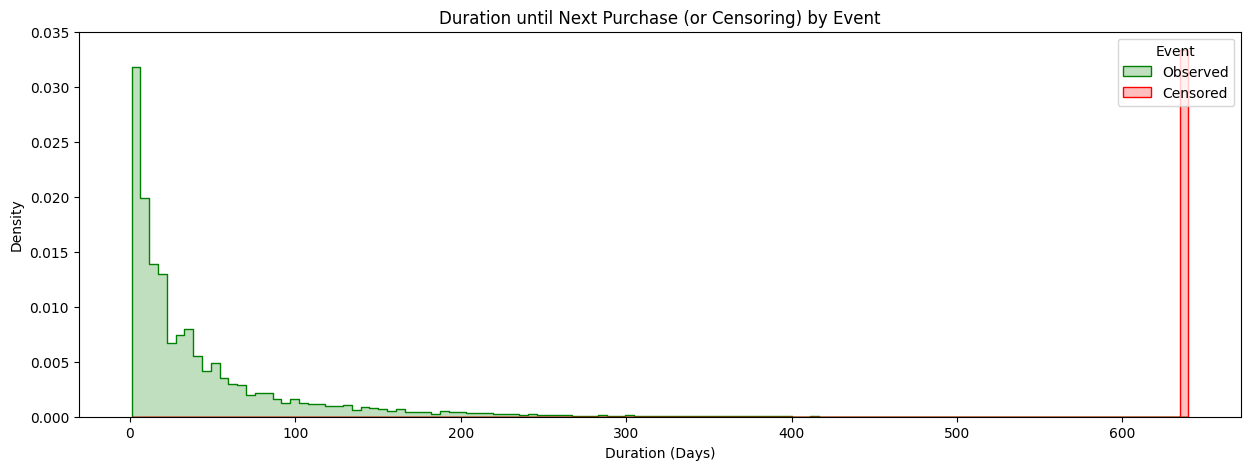

In [174]:
# Plotting the duration again with corrected color coding
plt.figure(figsize=(15, 5))
sns.histplot(data=data_grouped_sorted, x="Duration", hue="Event", bins=120, palette={0: 'red', 1: 'green'}, element="step", stat="density")
plt.xlabel("Duration (Days)")
plt.ylabel("Density")
plt.title("Duration until Next Purchase (or Censoring) by Event")
plt.legend(title="Event", labels=["Observed", "Censored"], loc="upper right")
plt.show()


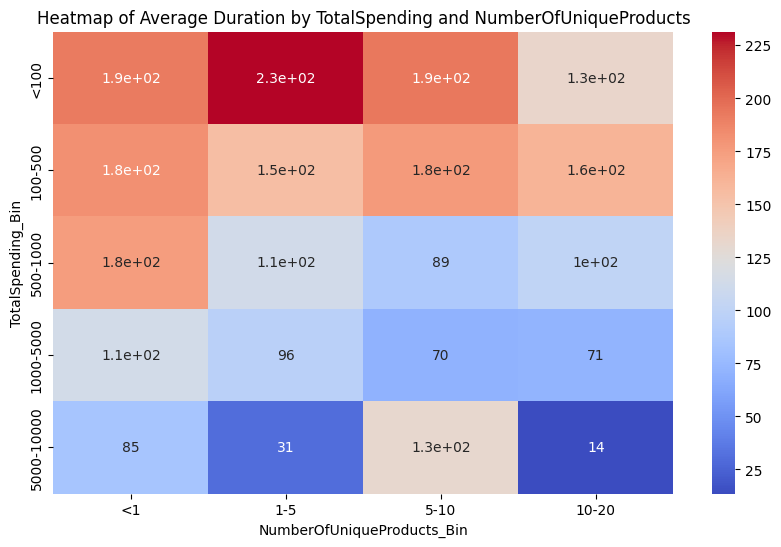

In [127]:
# 4. Heatmap of 'Duration' by binned 'TotalSpending' and 'NumberOfUniqueProducts'
# First create bins for 'TotalSpending' and 'NumberOfUniqueProducts'
data_grouped_sorted['TotalSpending_Bin'] = pd.cut(data_grouped_sorted['TotalSpending'], bins=[0, 100, 500, 1000, 5000, 10000], labels=['<100', '100-500', '500-1000', '1000-5000', '5000-10000'])
data_grouped_sorted['NumberOfUniqueProducts_Bin'] = pd.cut(data_grouped_sorted['NumberOfUniqueProducts'], bins=[0, 1, 5, 10, 20], labels=['<1', '1-5', '5-10', '10-20'])

# Now create the heatmap
pivot_table = pd.pivot_table(data_grouped_sorted, values='Duration', index=['TotalSpending_Bin'], columns=['NumberOfUniqueProducts_Bin'], aggfunc=np.mean)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
plt.title('Heatmap of Average Duration by TotalSpending and NumberOfUniqueProducts')
plt.show()

## This is great but it looks like I need something more descriptive about the customers, such as what products they buy etc. 

Perhaps using embeddings would be a good way to do this. I could feed initialize the system with one random vector for each customer. Then arrange the data So that I mapped each customer to a number and then arranged the data so I mapped each product to a number. I then want to train my neural net on observations of customer, product and qunatity combinations. Could this work? This way each customer could be represented in a n-dimensional space and it would be relatively easy to compare them against each other. Also, when I sampled new customers I could simply sample from the embedding space where the joint probability of all the products the customer buys is evaluated. I then need some way to translate between the embedding space and the real space of products.

In [102]:

# Splitting the data into training and testing sets
train, test = train_test_split(data_grouped_sorted, test_size=0.2, random_state=42)

In [103]:
colNames = list(data_grouped_sorted.columns.values)

,TotalSpending,NumberOfUniqueProducts,Quantity,Duration,Event,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,611.530029,40,509,37.0,1,-8.660254e-01,5.000000e-01,-0.781831,0.623490
1,1423.579956,31,638,50.0,1,-2.449294e-16,1.000000e+00,0.781831,0.623490
2,475.390015,29,315,71.0,1,5.000000e-01,8.660254e-01,0.974928,-0.222521
3,636.250000,24,483,63.0,1,8.660254e-01,-5.000000e-01,0.433884,-0.900969
4,382.519989,18,196,640.0,0,1.224647e-16,-1.000000e+00,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...
28848,-5.100000,1,-2,167.0,1,-2.449294e-16,1.000000e+00,0.781831,0.623490
28849,1071.609985,54,732,127.0,1,5.000000e-01,-8.660254e-01,0.000000,1.000000
28850,892.599976,21,508,62.0,1,-1.000000e+00,-1.836970e-16,0.781831,0.623490
28851,381.500000,10,187,181.0,1,-5.000000e-01,8.660254e-01,0.000000,1.000000


In [82]:
from lifelines import CoxPHFitter

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()


In [83]:
# Fit the model to the training data
cph.fit(train, duration_col='Duration', event_col='Event', show_progress=True)


Iteration 1: norm_delta = 0.23425, step_size = 0.9500, log_lik = -178720.92938, newton_decrement = 294.28468, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.03296, step_size = 0.9500, log_lik = -179155.51249, newton_decrement = 427.04122, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.02632, step_size = 0.9500, log_lik = -178656.71101, newton_decrement = 100.88516, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.02813, step_size = 1.0000, log_lik = -178531.93126, newton_decrement = 28.09929, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.01408, step_size = 0.9800, log_lik = -178498.38487, newton_decrement = 5.18941, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00424, step_size = 0.9604, log_lik = -178492.63627, newton_decrement = 0.31597, seconds_since_start = 0.2
Iteration 7: norm_delta = 0.00025, step_size = 1.0000, log_lik = -178492.30892, newton_decrement = 0.00100, seconds_since_start = 0.3
Iteration 8: norm_delta = 0.00000, step_size = 1.0000, 

<lifelines.CoxPHFitter: fitted with 23082 total observations, 4111 right-censored observations>

In [84]:
from lifelines.utils import concordance_index
c_index = concordance_index(test['Duration'], -cph.predict_partial_hazard(test), test['Event'])
print(f"C-index: {c_index}")


C-index: 0.5327935431074783


In [89]:
cph.check_assumptions(training_df=train, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 23082 total observations, 4111 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
DayOfWeek_cos          km              3.25   0.07      3.81
                       rank            3.12   0.08      3.69
DayOfWeek_sin          km             11.50 <0.005     10.49
                       rank           12.11 <0.005     10.96
Month_cos              km             91.00 <0.005     69.24
                       rank           90.32 <0.005     68.74
Month_sin              km             32.54 <0.005     26.35
                       rank           32.34 <0.005     26.20
NumberOfUniqueProducts km              7.88 <0.005      7.65
                       rank            7.57   0.01      7.39
Quantity               km              0.34   0.56      0.84
                       rank            0.35   0.55      0.85
TotalSpending          km              0.00   0.97      0.04
                       rank            0.00   0.96      0.06



1. Variable 'NumberOfUniqueProducts' failed the non-proportional test: p-value is 0.0050.

   Advice 1: the functional form of the variable 'NumberOfUniqueProducts' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'NumberOfUniqueProducts' using pd.cut, and then specify it in
`strata=['NumberOfUniqueProducts', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Month_sin' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'Month_sin' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See docu

[]

In [91]:
schoenfeld_residuals = cph.compute_residuals(train, 'schoenfeld')

In [92]:
schoenfeld_residuals

covariate,TotalSpending,NumberOfUniqueProducts,Quantity,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
12909,-917.445809,-19.338321,-422.190674,-0.095629,0.908639,0.163486,-0.882539
12027,-712.265801,19.661679,-251.190674,0.404371,-0.957387,0.163486,-0.882539
16155,-744.695809,22.661679,-358.190674,0.770396,-0.591361,0.511434,0.641919
13776,-10.045846,-13.338321,-186.190674,0.770396,0.408639,0.704530,-0.204091
2847,-920.395809,-19.338321,-423.190674,-0.095629,-1.091361,-0.270397,1.018430
...,...,...,...,...,...,...,...
14211,-343.883481,-17.427073,-231.548623,0.426441,0.974912,0.709293,-0.195057
9611,-219.568787,-16.431902,-134.612795,0.426559,0.975182,0.516393,0.650900
18782,-219.480112,-11.436492,-173.650393,-0.073322,1.109429,0.168589,-0.873377
6212,324.309532,24.560312,141.301082,0.426658,0.975764,-0.699131,-0.873621


In [87]:
predictions = cph.predict_survival_function(test)

In [88]:
predictions

,17333,9071,14881,6188,27057,20656,14202,11617,15817,5221,...,6759,20655,16467,11389,19121,21875,26555,27451,4424,17050
1.0,0.963502,0.967389,0.971659,0.968273,0.963897,0.971464,0.971146,0.952128,0.970718,0.970290,...,0.970580,0.971795,0.969691,0.966951,0.960080,0.971758,0.962082,0.962363,0.969415,0.970373
2.0,0.934645,0.941511,0.949078,0.943076,0.935342,0.948732,0.948168,0.914684,0.947408,0.946650,...,0.947165,0.949320,0.945588,0.940735,0.928618,0.949254,0.932142,0.932637,0.945098,0.946797
3.0,0.907292,0.916902,0.927529,0.919096,0.908266,0.927042,0.926248,0.879532,0.925180,0.924114,...,0.924838,0.927868,0.922622,0.915814,0.898883,0.927775,0.903797,0.904488,0.921934,0.924321
4.0,0.880315,0.892552,0.906130,0.895352,0.881553,0.905507,0.904492,0.845193,0.903125,0.901762,...,0.902687,0.906565,0.899855,0.891165,0.869640,0.906446,0.875874,0.876752,0.898976,0.902027
5.0,0.853033,0.867844,0.884338,0.871240,0.854530,0.883580,0.882345,0.810805,0.880682,0.879025,...,0.880150,0.884868,0.876708,0.866163,0.840154,0.884722,0.847671,0.848730,0.875640,0.879347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513.0,0.148993,0.183108,0.229424,0.191876,0.152154,0.227079,0.223306,0.081111,0.218318,0.213448,...,0.216743,0.231074,0.206805,0.178904,0.124174,0.230620,0.138154,0.140236,0.203810,0.214386
516.0,0.148952,0.183063,0.229375,0.191830,0.152112,0.227030,0.223257,0.081081,0.218270,0.213400,...,0.216695,0.231025,0.206757,0.178859,0.124137,0.230571,0.138114,0.140196,0.203762,0.214338
524.0,0.148910,0.183017,0.229326,0.191784,0.152070,0.226981,0.223208,0.081051,0.218222,0.213352,...,0.216646,0.230976,0.206710,0.178814,0.124099,0.230521,0.138074,0.140156,0.203715,0.214290
540.0,0.148869,0.182972,0.229276,0.191737,0.152029,0.226932,0.223159,0.081022,0.218173,0.213304,...,0.216598,0.230926,0.206662,0.178769,0.124061,0.230472,0.138034,0.140116,0.203668,0.214242


In [ ]:
cph.print_summary()


In [105]:
from lifelines import WeibullFitter

wf = WeibullFitter()
wf.fit(train['Duration'], event_observed=train['Event'])

# To evaluate
wf.print_summary()


<lifelines.WeibullFitter:"Weibull_estimate", fitted with 23082 total observations, 4111 right-censored observations>
   number of observations = 23082
number of events observed = 18971
           log-likelihood = -106300.74
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 121.22       1.84           117.62           124.83
rho_      0.48       0.00             0.48             0.49

          cmp to       z      p   -log2(p)
lambda_     1.00   65.35 <0.005        inf
rho_        1.00 -186.47 <0.005        inf
---
AIC = 212605.48

In [106]:
# Note: you'll use the 'survival_function_at_times' method to get the survival times
predicted_survival_times = wf.survival_function_at_times(test['Duration'])

# Calculate the concordance index
c_index = concordance_index(test['Duration'], 1 - predicted_survival_times, test['Event'])
print(f"C-index: {c_index}")

ValueError: NaNs detected in inputs, please correct or drop.

In [112]:
test[test['Event'].isnull()]

,TotalSpending,NumberOfUniqueProducts,Quantity,Duration,Event,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos


In [113]:
predicted_survival_times = wf.survival_function_at_times(test['Duration'])

In [114]:
predicted_survival_times

316.0    0.454526
1.0           NaN
640.0    0.740202
14.0          NaN
640.0    0.740202
           ...   
1.0           NaN
640.0    0.740202
143.0         NaN
640.0    0.740202
7.0           NaN
Name: Weibull_estimate, Length: 5771, dtype: float64

In [98]:
help(wf)

Help on WeibullFitter in module lifelines.fitters.weibull_fitter object:

class WeibullFitter(lifelines.fitters.KnownModelParametricUnivariateFitter)
 |  WeibullFitter(*args, **kwargs)
 |  
 |  This class implements a Weibull model for univariate data. The model has parameterized
 |  form:
 |  
 |  .. math::  S(t) = \exp\left(-\left(\frac{t}{\lambda}\right)^\rho\right),   \lambda > 0, \rho > 0,
 |  
 |  The :math:`\lambda` (scale) parameter has an applicable interpretation: it represents the time when 63.2% of the population has died.
 |  The :math:`\rho` (shape) parameter controls if the cumulative hazard (see below) is convex or concave, representing accelerating or decelerating
 |  hazards.
 |  
 |  .. image:: /images/weibull_parameters.png
 |  
 |  The cumulative hazard rate is
 |  
 |  .. math:: H(t) = \left(\frac{t}{\lambda}\right)^\rho,
 |  
 |  and the hazard rate is:
 |  
 |  .. math::  h(t) = \frac{\rho}{\lambda}\left(\frac{t}{\lambda}\right)^{\rho-1}
 |  
 |  After calling t

In [96]:
# Reload the data and reapply the transformations
data = 


In [100]:
import pandas as pd

# Reload the dataset
training_data = pd.read_csv('/home/hcekne/data/online_retail_ii/training_data.csv', parse_dates=['InvoiceDate'])

# Group by Customer ID, Invoice, and InvoiceDate
grouped_data = training_data.groupby(['Customer ID', 'Invoice', 'InvoiceDate']).agg({
    'TotalSpending': 'sum',
    'StockCode': 'nunique',
}).reset_index()

# Rename columns for clarity
grouped_data.rename(columns={'StockCode': 'UniqueProducts'}, inplace=True)

# Sort the data by Customer ID and InvoiceDate
grouped_data.sort_values(by=['Customer ID', 'InvoiceDate'], inplace=True)

# Compute the DaysSinceLastPurchase
grouped_data['DaysSinceLastPurchase'] = grouped_data.groupby('Customer ID')['InvoiceDate'].diff().dt.days

# Extract Month and DayOfWeek
grouped_data['Month'] = grouped_data['InvoiceDate'].dt.month
grouped_data['DayOfWeek'] = grouped_data['InvoiceDate'].dt.dayofweek

# Calculate cumulative sum of TotalSpending till that transaction date
grouped_data['TotalSpendingTillDate'] = grouped_data.groupby('Customer ID')['TotalSpending'].cumsum() - grouped_data['TotalSpending']

# Calculate number of previous transactions
grouped_data['NumPreviousPurchases'] = grouped_data.groupby('Customer ID').cumcount()

grouped_data.head(20)


,Customer ID,Invoice,InvoiceDate,TotalSpending,UniqueProducts,DaysSinceLastPurchase,Month,DayOfWeek,TotalSpendingTillDate,NumPreviousPurchases
0,12347.0,529924,2010-10-31,611.530013,40,NaN,10,6,0.000000,0
1,12347.0,537626,2010-12-07,1423.579998,31,37.0,12,1,611.530013,1
2,12347.0,542237,2011-01-26,475.390008,29,50.0,1,2,2035.110011,2
3,12347.0,549222,2011-04-07,636.249995,24,71.0,4,3,2510.500018,3
4,12347.0,556201,2011-06-09,382.520005,18,63.0,6,3,3146.750013,4
5,12348.0,524140,2010-09-27,222.160017,20,NaN,9,0,0.000000,0
6,12348.0,539318,2010-12-16,892.800009,13,80.0,12,3,222.160017,1
7,12348.0,541998,2011-01-25,227.440002,6,40.0,1,1,1114.960026,2
8,12348.0,548955,2011-04-05,367.000000,5,70.0,4,1,1342.400028,3
12,12349.0,C490283,2009-12-04,-24.150000,5,NaN,12,4,0.000000,0


In [98]:
# Display the first few rows of the dataset with the new features
data.head(20)

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDatetime,Price,Customer ID,Country,TotalSpending,PriceCategory,YearMonth,InvoiceDate,Weekday,DaysSinceLastPurchase,Month,DayOfWeek,TotalSpendingTillDate,NumPreviousPurchases,UniqueProducts
340169,340169,529924,22698,PINK REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700000,Very Low,2010-10,2010-10-31,Sunday,NaN,10,6,0.000000,0,40
340170,340170,529924,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700000,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,17.700000,1,40
340171,340171,529924,20985,HEART CALCULATOR,12,2010-10-31 14:20:00,1.25,12347.0,Iceland,15.000000,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,35.400000,2,40
340172,340172,529924,22418,10 COLOUR SPACEBOY PEN,24,2010-10-31 14:20:00,0.85,12347.0,Iceland,20.400002,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,50.400000,3,40
340173,340173,529924,22422,TOOTHPASTE TUBE PEN,12,2010-10-31 14:20:00,0.65,12347.0,Iceland,7.800000,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,70.800002,4,40
340174,340174,529924,51014A,"FEATHER PEN,HOT PINK",12,2010-10-31 14:20:00,0.85,12347.0,Iceland,10.200001,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,78.600002,5,40
340175,340175,529924,51014C,"FEATHER PEN,COAL BLACK",12,2010-10-31 14:20:00,0.85,12347.0,Iceland,10.200001,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,88.800003,6,40
340176,340176,529924,51014L,"FEATHER PEN,LIGHT PINK",12,2010-10-31 14:20:00,0.85,12347.0,Iceland,10.200001,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,99.000004,7,40
340177,340177,529924,22709,WRAP WEDDING DAY,25,2010-10-31 14:20:00,0.42,12347.0,Iceland,10.500000,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,109.200005,8,40
340178,340178,529924,22045,SPACEBOY GIFT WRAP,25,2010-10-31 14:20:00,0.42,12347.0,Iceland,10.500000,Very Low,2010-10,2010-10-31,Sunday,0.0,10,6,119.700005,9,40


In [101]:
# Reload the dataset
training_data = pd.read_csv('/home/hcekne/data/online_retail_ii/training_data.csv', parse_dates=['InvoiceDate'])


# Group the data by Customer ID, InvoiceDate, and Invoice
data_grouped = data.groupby(['Customer ID', 'InvoiceDate', 'Invoice']).agg({
    'StockCode': 'nunique',  # Count of unique products
    'TotalSpending': 'sum'  # Total spending for the invoice
}).reset_index()

# Sort the data by Customer ID and InvoiceDate for calculating time since last purchase
data_grouped.sort_values(by=['Customer ID', 'InvoiceDate'], inplace=True)

# Calculate days since last purchase for each customer
data_grouped['DaysSinceLastPurchase'] = data_grouped.groupby('Customer ID')['InvoiceDate'].diff().dt.days

# Replace NaN values in DaysSinceLastPurchase with 0
data_grouped['DaysSinceLastPurchase'].fillna(0, inplace=True)

# this doesn't really work with this target variable.. it would only work if you had one row for every customer for every day of the training data history.. but this seems like a very inefficient way of computing what we want
# Create the target variable
#data_grouped['NextPurchaseDate'] = data_grouped.groupby('Customer ID')['InvoiceDate'].shift(-1)
#data_grouped['DaysToNextPurchase'] = (data_grouped['NextPurchaseDate'] - data_grouped['InvoiceDate']).dt.days

# If DaysToNextPurchase is 1, then the customer made a purchase the next day
#data_grouped['PurchaseNextDay'] = (data_grouped['DaysToNextPurchase'] == 1).astype(int)

# Drop unnecessary columns
#data_grouped.drop(columns=['NextPurchaseDate', 'DaysToNextPurchase'], inplace=True)

#data_grouped.head()


,Customer ID,InvoiceDate,Invoice,StockCode,TotalSpending,DaysSinceLastPurchase,PurchaseNextDay
0,12347.0,2010-10-31,529924,40,611.530013,0.0,0
1,12347.0,2010-12-07,537626,31,1423.579998,37.0,0
2,12347.0,2011-01-26,542237,29,475.390008,50.0,0
3,12347.0,2011-04-07,549222,24,636.249995,71.0,0
4,12347.0,2011-06-09,556201,18,382.520005,63.0,0


---

In [319]:
# Convert 'InvoiceDate' to datetime and extract weekday names
daily_new_customers['Weekday'] = daily_new_customers['InvoiceDatetime'].dt.day_name()

In [269]:
#daily_new_customers.to_csv('/home/hcekne/data/online_retail_ii/daily_new_customers.csv')

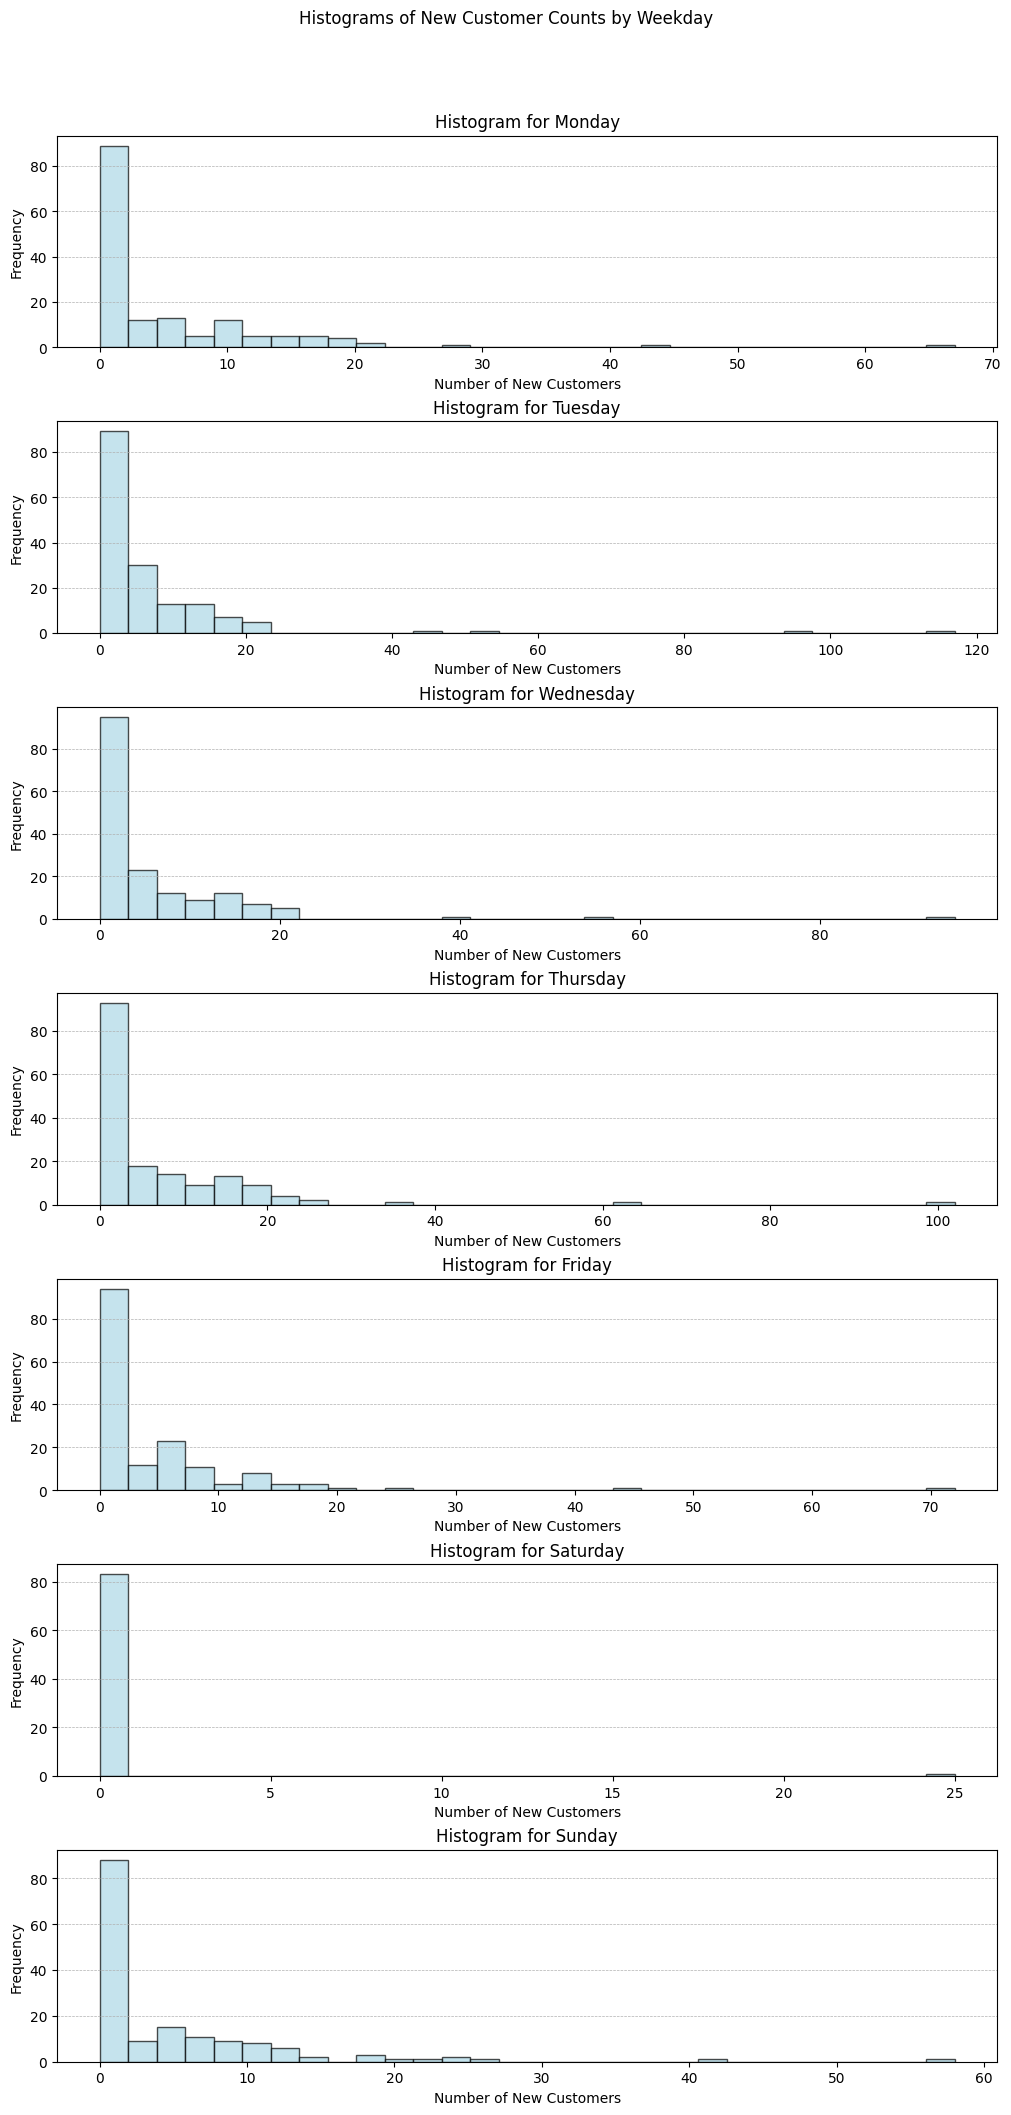

In [325]:
fig, axes = plt.subplots(7, 1, figsize=(10, 20), constrained_layout=True)

for ax, day in zip(axes, days_of_week):
    subset = daily_new_customers[daily_new_customers['Weekday'] == day]['newCustomerCount']
    ax.hist(subset, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
    ax.set_title(f'Histogram for {day}')
    ax.set_xlabel('Number of New Customers')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.suptitle('Histograms of New Customer Counts by Weekday', y=1.05)
plt.show()

---

In [44]:
country_grouped = training_data.groupby('Country').agg({
    'Customer ID': 'nunique',  # Number of unique customers
    'Invoice': 'nunique',      # Number of unique invoices
    'TotalSpending': 'sum',    # Total spending
    'Price': ['mean', 'std'],  # Average and standard deviation of item prices
    'Quantity': ['mean', 'std'] # Average and standard deviation of quantities
})

country_grouped.columns = ['_'.join(col).strip() for col in country_grouped.columns.values]

country_grouped.reset_index(inplace=True)

country_grouped.sort_values(by='TotalSpending_sum', ascending=False, inplace=True)  # Sort by total spending for better visualization

country_grouped

,Country,Customer ID_nunique,Invoice_nunique,TotalSpending_sum,Price_mean,Price_std,Quantity_mean,Quantity_std
38,United Kingdom,4694,30670,1.017630e+07,3.620188,80.390929,11.371432,66.509351
10,EIRE,5,538,4.288108e+05,7.808676,73.072767,19.705045,52.312784
24,Netherlands,23,198,4.036132e+05,3.063473,17.254038,70.173144,93.734549
14,Germany,84,777,3.043103e+05,3.725758,14.268966,12.904962,20.771478
13,France,70,503,2.210733e+05,4.117410,43.631954,13.089901,260.574358
0,Australia,15,85,1.108840e+05,4.784857,31.412170,53.018100,79.726701
33,Sweden,17,104,6.913339e+04,6.919801,53.180627,64.558477,136.221882
34,Switzerland,19,81,6.765174e+04,4.123748,19.987634,17.914170,22.351594
32,Spain,35,134,6.669667e+04,6.292310,50.022023,13.019758,49.323843
9,Denmark,10,39,5.640951e+04,2.900637,3.576337,376.632353,1644.100230
